In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def lot_conversion(value):
    '''
    Converts lot in acres to sqft.
    Convert value from string to float.
    
    Input:
    value: str. value of lot (i.e. '4123 acres')
    
    Ouput:
    value: float. value of lot in sqft 
    '''
    if isinstance(value,str):
        if 'No' in value:
            return np.nan
        lot,unit = value.split(' ')
        value = float(lot.replace(',',''))
        if unit=='acres':
            value*=43560
    return value

def clean_price(value):
    '''
    Removes $ and , from price string.
    Convert value from string to float. 
    
    Input:
    value: str. value of price (i.e. '$2,134')
    
    Ouput:
    value: float. value of price 
    '''
    if isinstance(value,str):
        if 'No' in value:
            return np.nan
        value = value.replace('$','')
        value = value.replace(',','')
        value = float(value)
    return value

def clean_categories(value):
    if isinstance(value,str):
        if 'No Data' in value:
            return np.nan
        value = value.strip()
    return value

def one_hot_encoding(series):
    '''
    Customized Onehot encoding for handling multiple value answers
    
    Input:
    series: pandas series containing the values of the feature
    
    Output:
    oh_df: dataframe contains the one hot encoded values of the input series
    
    '''
    one_hot = []
    cat_list = series.str.split(', ').explode().str.strip().dropna().unique()
    for val in series.values:
        one_hot.append([1 if cat in str(val) else 0 for cat in cat_list])
        
    oh_df = pd.DataFrame(one_hot,columns=cat_list)
    return oh_df

In [3]:
for_sale = pd.read_csv('for_sale_raw.csv')
for_sale['ListType'] = 'For Sale'
sold = pd.read_csv('sold_raw.csv')
sold['ListType'] = 'Sold'

df = pd.concat([for_sale,sold],axis=0)

In [4]:
keep = ['Price','ListType','Street','State','City','Zipcode',
        'Beds', 'Baths','Area', 'Latlong','Type', 'Year Built',
        'Heating', 'Cooling','Parking', 'Lot', 'Price/Sqft',
        'Full Bathrooms', '3/4 Bathrooms','1/2 Bathrooms', '1/4 Bathrooms',
        'Basement', 'Flooring', 'Total Interior Livable Area',
        'Fireplace', 'Stories', 'Exterior Features',
        'Roof','Tax Assessed Value']
df = df[keep]
df.shape

(1515, 29)

In [5]:
# subset to data in Rochester
city = df['City']=='Rochester'
df = df[city]
df.drop(columns=['City','State'],inplace=True)

# subset to rows with price value
with_price = df['Price']>0
df = df[with_price]

# remove duplicated rows
cols = ['Street','Zipcode','Latlong','Price']
df = df.drop_duplicates(subset=cols)

df.reset_index(drop=True,inplace=True)
df.shape

(1185, 27)

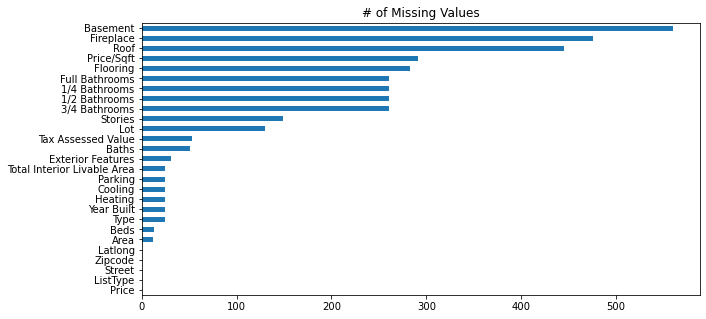

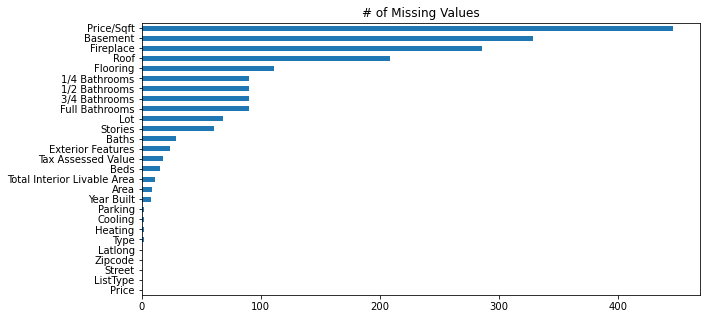

In [6]:
for listtype in ['For Sale','Sold']:
    plt.figure(figsize=(10,5))
    cond = df['ListType']==listtype
    df[cond].isna().sum().sort_values().plot.barh()
    plt.title('# of Missing Values')
    plt.show()

In [7]:
df[['Lat','Lon']] = df['Latlong'].str.split(', ',expand=True)

df['Lat'] = df['Lat'].str.split(': ').str[-1]
df['Lon'] = df['Lon'].str.split(': ').str[-1].str.replace('}','')

df['Lat'] = pd.to_numeric(df['Lat'])
df['Lon'] = pd.to_numeric(df['Lon'])

df.drop(columns=['Latlong'],inplace=True)
df.shape

(1185, 28)

In [8]:
to_numeric = ['Year Built','Lot','Price/Sqft',
               'Total Interior Livable Area','Tax Assessed Value']
df[to_numeric].head()

,Year Built,Lot,Price/Sqft,Total Interior Livable Area,Tax Assessed Value
0,1890,"4,891 sqft",$21,"1,932 sqft","$30,612"
1,1955,0.34 acres,$130,"1,188 sqft","$115,000"
2,1900,"4,207 sqft",$25,"1,316 sqft","$23,980"
3,1940,"6,484 sqft",$94,"1,327 sqft","$78,571"
4,1950,0.3 acres,$87,"1,376 sqft","$97,200"


In [9]:
df['Year Built'] = pd.to_numeric(df['Year Built'],errors='coerce')

df['Lot'] = df['Lot'].apply(lot_conversion)
df['Total Interior Livable Area'] = df['Total Interior Livable Area'].apply(lot_conversion)

df['Price/Sqft'] = df['Price/Sqft'].apply(clean_price)
df['Tax Assessed Value'] = df['Tax Assessed Value'].apply(clean_price)

# Price/Sqft = Price / Total Livable Area (Sqft)
# Computed to fill in missing data values
df['Price/Sqft'] = np.round(df['Price']/df['Total Interior Livable Area'])

df[['Price']+to_numeric].head()

,Price,Year Built,Lot,Price/Sqft,Total Interior Livable Area,Tax Assessed Value
0,39900.0,1890.0,4891.0,21.0,1932.0,30612.0
1,155000.0,1955.0,14810.4,130.0,1188.0,115000.0
2,32900.0,1900.0,4207.0,25.0,1316.0,23980.0
3,125000.0,1940.0,6484.0,94.0,1327.0,78571.0
4,119900.0,1950.0,13068.0,87.0,1376.0,97200.0


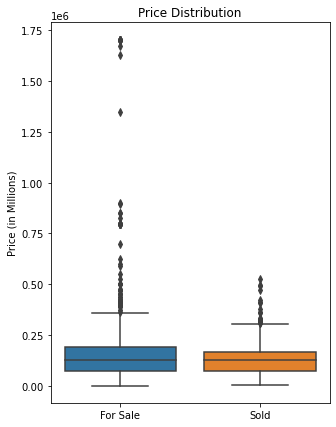

In [10]:
plt.figure(figsize=(5,7))
sns.boxplot(x="ListType", y="Price", data=df)
plt.xlabel('')
plt.ylabel('Price (in Millions)')
plt.title('Price Distribution');

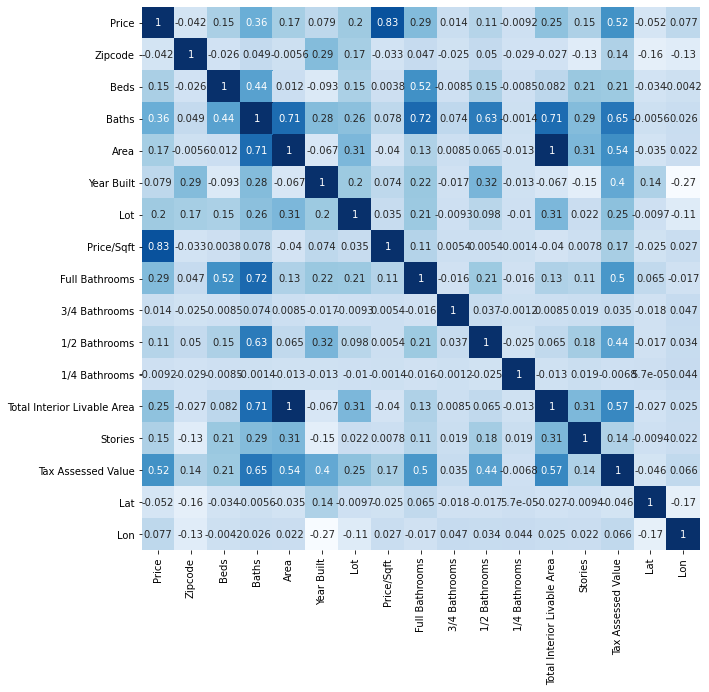

In [11]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),annot=True,cmap='Blues',cbar=False)

<Figure size 504x720 with 0 Axes>

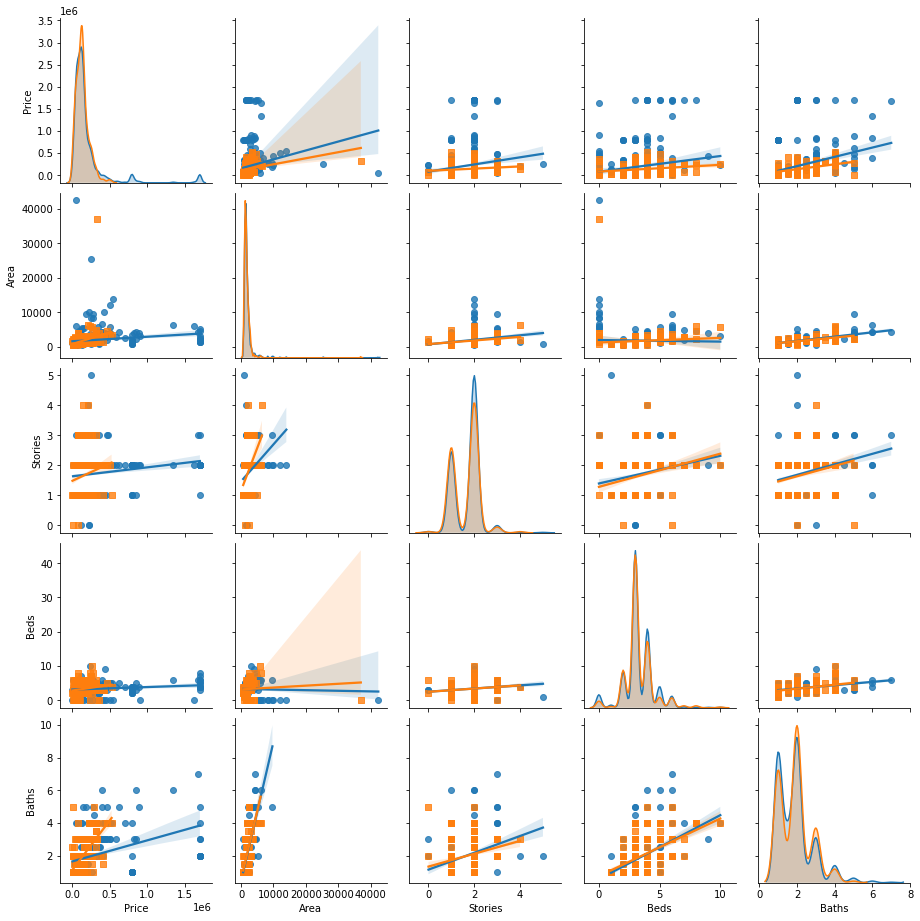

In [12]:
cols = ['Price','Area','Stories','Beds','Baths','ListType']
plt.figure(figsize=(7,10))
g=sns.pairplot(df[cols],hue='ListType',markers=["o", "s"],
             kind="reg")
g._legend.remove();

In [13]:
multi_cat = ['Heating','Parking','Flooring','Exterior Features']

single_cat = ['Type', 'Cooling',
              'Basement', 'Fireplace', 'Roof']
cat_cols = single_cat+multi_cat
df[cat_cols].head()

,Type,Cooling,Basement,Fireplace,Roof,Heating,Parking,Flooring,Exterior Features
0,Single Family,No Data,Unfinished,NaN,NaN,Forced air,2 spaces,"Carpet, Laminate, Linoleum / Vinyl",Composition
1,Single Family,Central,NaN,NaN,Asphalt,Other,2 spaces,"Hardwood, Laminate, Tile",Vinyl
2,Single Family,No Data,NaN,NaN,NaN,Forced air,No Data,"Carpet, Hardwood, Linoleum / Vinyl",Composition
3,Single Family,Central,Partially finished,NaN,Asphalt,Forced air,3 spaces,"Carpet, Hardwood, Linoleum / Vinyl, Slate, Tile",Vinyl
4,Single Family,No Data,NaN,NaN,Asphalt,Forced air,No Data,"Hardwood, Linoleum / Vinyl",Wood


In [14]:
for col in cat_cols:
    df[col] = df[col].apply(clean_categories)

print(df.shape)
df = pd.get_dummies(df,columns=single_cat,prefix_sep=': ',
                    dummy_na=False,drop_first=False)
print(df.shape)

encoded_df = pd.DataFrame()
for col in multi_cat:
    encoded = one_hot_encoding(df[col]).add_prefix(col+': ')
    encoded_df = pd.concat([encoded_df,encoded],axis=1)

print(df.shape,encoded_df.shape)
df.drop(columns=multi_cat,inplace=True)
df = pd.concat([df,encoded_df],axis=1)
    
print(df.shape)

(1185, 28)
(1185, 56)
(1185, 56) (1185, 55)
(1185, 107)


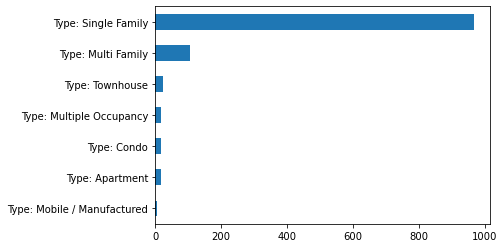

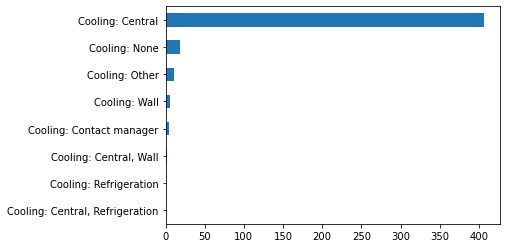

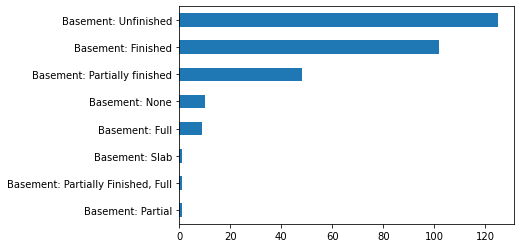

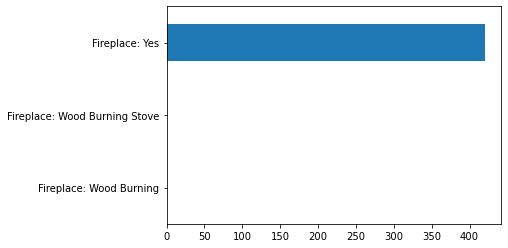

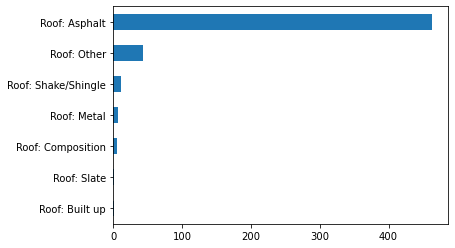

In [15]:
for col in single_cat:
    dummy_cols = [c for c in df.columns if col+':' in c]
    df[dummy_cols].sum().sort_values().plot.barh()
    plt.show()

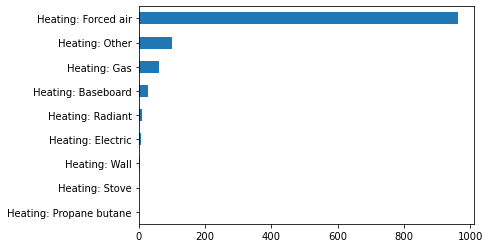

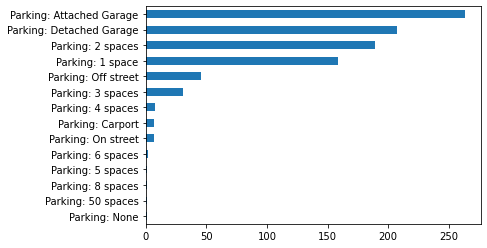

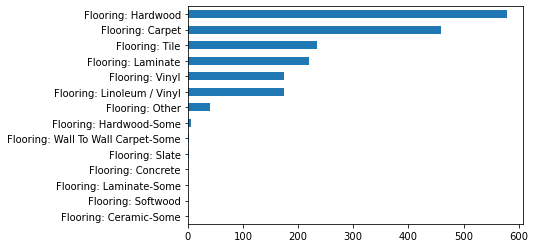

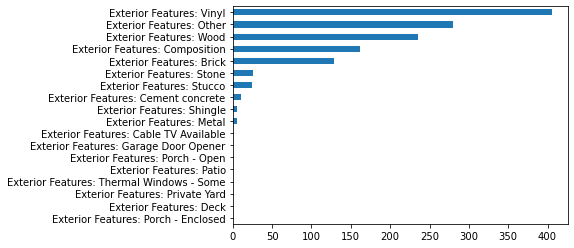

In [16]:
for col in multi_cat:
    dummy_cols = [c for c in df.columns if col in c]
    df[dummy_cols].sum().sort_values().plot.barh()
    plt.show()

In [17]:
df.to_csv('Real_Estate_Listings.csv',index=False)